# Ames Housing Project Suggestions

Data science is not a linear process. In this project, in particular, you will likely find that EDA, data cleaning, and exploratory visualizations will constantly feed back into each other. Here's an example:

1. During basic EDA, you identify many missing values in a column/feature.
2. You consult the data dictionary and use domain knowledge to decide _what_ is meant by this missing feature.
3. You impute a reasonable value for the missing value.
4. You plot the distribution of your feature.
5. You realize what you imputed has negatively impacted your data quality.
6. You cycle back, re-load your clean data, re-think your approach, and find a better solution.

Then you move on to your next feature. _There are dozens of features in this dataset._

Figuring out programmatically concise and repeatable ways to clean and explore your data will save you a lot of time.

The outline below does not necessarily cover every single thing that you will want to do in your project. You may choose to do some things in a slightly different order. Many students choose to work in a single notebook for this project. Others choose to separate sections out into separate notebooks. Check with your local instructor for their preference and further suggestions.

## EDA
- **Read the data dictionary.**
- Determine _what_ missing values mean.
- Figure out what each categorical value represents.
- Identify outliers.
- Consider whether discrete values are better represented as categorical or continuous. (Are relationships to the target linear?)

## Data Cleaning
- Decide how to impute null values.
- Decide how to handle outliers.
- Do you want to combine any features?
- Do you want to have interaction terms?
- Do you want to manually drop collinear features?

## Exploratory Visualizations
- Look at distributions.
- Look at correlations.
- Look at relationships to target (scatter plots for continuous, box plots for categorical).

## Pre-processing
- One-hot encode categorical variables.
- Train/test split your data.
- Scale your data.
- Consider using automated feature selection.

## Modeling
- **Establish your baseline score.**
- Fit linear regression. Look at your coefficients. Are any of them wildly overblown?
- Fit lasso/ridge/elastic net with default parameters.
- Go back and remove features that might be causing issues in your models.
- Tune hyperparameters.
- **Identify a production model.** (This does not have to be your best performing Kaggle model, but rather the model that best answers your problem statement.)
- Refine and interpret your production model.

## Inferential Visualizations
- Look at feature loadings.
- Look at how accurate your predictions are.
- Is there a pattern to your errors? Consider reworking your model to address this.

## Business Recommendations
- Which features appear to add the most value to a home?
- Which features hurt the value of a home the most?
- What are things that homeowners could improve in their homes to increase the value?
- What neighborhoods seem like they might be a good investment?
- Do you feel that this model will generalize to other cities? How could you revise your model to make it more universal OR what date would you need from another city to make a comparable model?

# Example Directory Structure
Here's how you might structure a project with multiple notebooks.

```
project-2
|__ code
|   |__ 01_EDA_and_Cleaning.ipynb   
|   |__ 02_Preprocessing_and_Feature_Engineering.ipynb   
|   |__ 03_Model_Benchmarks.ipynb
|   |__ 04_Model_Tuning.ipynb  
|   |__ 05_Production_Model_and_Insights.ipynb
|   |__ 06_Kaggle_Submissions.ipynb   
|__ data
|   |__ train.csv
|   |__ test.csv
|   |__ submission_lasso.csv
|   |__ submission_ridge.csv
|__ images
|   |__ coefficients.png
|   |__ neighborhoods.png
|   |__ predictions.png
|__ presentation.pdf
|__ README.md
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
#Get datasets: NB, test is just read but will not be written over until modelling is done
test = '../datasets/test.csv'
train = '../datasets/train.csv'

In [3]:
test = pd.read_csv(test)
train = pd.read_csv(train)

In [4]:
#Annotate test and train sets
test['Is_test'] = 1
train['Is_test'] = 0
df = pd.concat([test,train],ignore_index=True,sort=False)
y = df['SalePrice']

In [5]:
# Remove PID and ID as columns as they are redundant
df = df.drop(labels =['Id','PID'],axis = 1)


In [6]:
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Is_test,SalePrice
0,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,1,NaN
1,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2006,WD,1,NaN
2,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,New,1,NaN
3,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2007,WD,1,NaN
4,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2009,WD,1,NaN


In [7]:
# Checking for nulls
df.isnull().sum().sort_values().tail(30)

##no. nulls similar columns might be related.

##From data dictionary, there are columns with NA columns to signify the absence of the additional ammenities
# Pandas dataframe automatically considers all NA columns as NaN, whereas the columns are actually a category by itself
#Need to check and replace all columns that are not in actual fact <blank>/missing

Exter Qual           0
Neighborhood         0
Total Bsmt SF        1
BsmtFin SF 2         1
Electrical           1
BsmtFin SF 1         1
Garage Area          1
Garage Cars          1
Bsmt Unf SF          1
Bsmt Half Bath       2
Bsmt Full Bath       2
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Qual           80
BsmtFin Type 1      80
Bsmt Cond           80
BsmtFin Type 2      81
Bsmt Exposure       83
Garage Type        157
Garage Qual        159
Garage Finish      159
Garage Yr Blt      159
Garage Cond        159
Lot Frontage       490
SalePrice          879
Fireplace Qu      1422
Fence             2358
Alley             2732
Misc Feature      2824
Pool QC           2917
dtype: int64

In [8]:
# If BsmtFin SF 1, SF 2 and total bsmt SF are NaN, total square feet (numeric) should be 0.
df[df['BsmtFin SF 1'].isnull()][['BsmtFin SF 1','Total Bsmt SF', 'BsmtFin SF 2', 'Bsmt Unf SF']]

,BsmtFin SF 1,Total Bsmt SF,BsmtFin SF 2,Bsmt Unf SF
2206,NaN,NaN,NaN,NaN


In [9]:
df=df.fillna({'BsmtFin SF 1':0, 'Total Bsmt SF': 0, 'BsmtFin SF 2':0,'Bsmt Unf SF':0})

In [10]:
# Null in Garage Area linked to null in garage cars
df[df['Garage Area'].isnull()][['Garage Cars']]

,Garage Cars
2591,NaN


In [11]:
# Garage area and car should be set to integer '0' if NaN.
df=df.fillna({'Garage Area':0,'Garage Cars':0})

In [12]:
# Null in electrical is linked to utilities; check has electricity
df[df['Electrical'].isnull()][['Electrical','Utilities']]

,Electrical,Utilities
635,NaN,AllPub


In [13]:
# Most houses with All Pub utilities, electrical holds standard breaker
df[df['Utilities'] == 'AllPub']['Electrical'].value_counts()

SBrkr    2682
FuseA     185
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [14]:
# Replace index 635 electrical with SBrkr
df.loc[635,'Electrical'] = 'SBrkr'

In [15]:
# Bsmt half or full bathroom, if NaN --> Set to 0.0
df=df.fillna({'Bsmt Half Bath':0.0, 'Bsmt Full Bath': 0.0})

In [16]:
# Masonry veneer type if NaN, set to None
# Masonry veneer area if NaN, set to '0'
df=df.fillna({'Mas Vnr Type':'None', 'Mas Vnr Area': 0.0})

In [17]:
#column in basment finish type 2 empty but not empty in type 1 check index number
df[df['BsmtFin Type 2'].isnull()]['BsmtFin Type 1'].sort_values(ascending = True).head()

2026    GLQ
15      NaN
37      NaN
77      NaN
79      NaN
Name: BsmtFin Type 1, dtype: object

In [18]:
df.loc[2026,['Bsmt Cond','Bsmt Qual','BsmtFin Type 1','BsmtFin Type 2','Bsmt Exposure']]

Bsmt Cond          TA
Bsmt Qual          Gd
BsmtFin Type 1    GLQ
BsmtFin Type 2    NaN
Bsmt Exposure      No
Name: 2026, dtype: object

In [19]:
# For most cases, when Bsmt cond = TA, quality = Gd, finish type 1 = GLQ and bsmt exposure = no, BsmtFin Type 2 is Unf
basement = df[(df['Bsmt Cond'] == 'TA') & (df['Bsmt Qual'] == 'Gd') & (df['BsmtFin Type 1'] == 'GLQ') & (df['Bsmt Exposure'] == 'No')].mode()
basement[['BsmtFin Type 2']].head(2)

,BsmtFin Type 2
0,Unf
1,NaN


In [20]:
df.loc[2026,'BsmtFin Type 2'] = 'Unf'

In [21]:
# For cases where exposure is null, There are values in basment condition, quality and finish type 1 and 2 in indices 2335, 2426 and 2876
df[df['Bsmt Exposure'].isnull()]['BsmtFin Type 2'].sort_values(ascending = True).head()

2335    Unf
2426    Unf
2876    Unf
15      NaN
37      NaN
Name: BsmtFin Type 2, dtype: object

In [22]:
# three cases, Cond = TA, Qual = Gd, Type 1 and 2 = Unf, mode of Bsmt Exposure to replace this three cases
basement = df[(df['Bsmt Cond'] == 'TA') & (df['Bsmt Qual'] == 'Gd') & (df['BsmtFin Type 1'] == 'Unf') & (df['BsmtFin Type 2'] == 'Unf')].mode()
basement[['Bsmt Exposure']].head(2)

,Bsmt Exposure
0,No
1,NaN


In [23]:
# Replace all 3 cases with exposure as 'No'
replacement = [2335, 2426, 2876]
for row in replacement:
    df.loc[row,'Bsmt Exposure'] = 'No'

In [24]:
# BsmtFin Type 1 and Type 2, Bsmt Qual, Cond and Exposure if NaN, set to "None"
df=df.fillna({'BsmtFin Type 1':'None',
              'BsmtFin Type 2':'None',
              'Bsmt Qual':'None',
              'Bsmt Cond':'None',
              'Bsmt Exposure':'None'
             })

In [25]:
# isnull for Garage type != Garage qual/cond/fin ----> 157 != 159;
# There is a row with garage type = Detchd but no quality, condition, finish and yr Belt
df[df['Garage Qual'].isnull()]['Garage Type'].sort_values(ascending = True).head(3)

765     Detchd
2591    Detchd
29         NaN
Name: Garage Type, dtype: object

In [26]:
# Show mode of Garage Qual, Cond, Finish and Yr Blt when Garage type == Detchd
garage = df[df['Garage Type'] == 'Detchd'].mode()
garage[['Garage Qual','Garage Cond','Garage Finish', 'Garage Yr Blt']].head()

,Garage Qual,Garage Cond,Garage Finish,Garage Yr Blt
0,TA,TA,Unf,1950.0
1,NaN,NaN,NaN,NaN


In [27]:
#For Garage type of 'Detached':
# Replace garage quality, condition, finish and year built of index 1712 with mode of each column
replacements = [765,2591]
for i in replacements:
    df.loc[i,'Garage Qual'] = 'TA'
    df.loc[i,'Garage Cond'] = 'TA'
    df.loc[i,'Garage Finish'] = 'Unf'
    df.loc[i,'Garage Yr Blt'] = 1950.0

In [28]:
df[['Garage Yr Blt']].mean()

Garage Yr Blt    1978.112153
dtype: float64

In [29]:
# Garage Type, Qual, Cond, Finish set to 'None' if NaN
# Garage Yr Blt set to mean to preserve mean year built
df=df.fillna({'Garage Type':'None',
              'Garage Qual':'None',
              'Garage Cond':'None',
              'Garage Finish':'None',
              'Garage Yr Blt':1978
             })

In [30]:
# Unusual data year 2207; to correct to 2007
df['Garage Yr Blt'].sort_values(ascending = False).head(3)

2578    2207.0
317     2010.0
453     2010.0
Name: Garage Yr Blt, dtype: float64

In [31]:
# Correcting year 2207 as 2007
df.loc[2578,'Garage Yr Blt'] = 2007.0

In [32]:
# For lot frontage, if NaN, replace value with 0.0 
df=df.fillna({'Lot Frontage': 0.0})

In [33]:
# For Fireplace quality, if fireplace = 0, quality should be 'None' 
df=df.fillna({'Fireplace Qu': 'None'})

In [34]:
# For Fence if NaN, should be 'None' 
df=df.fillna({'Fence': 'None'})

In [35]:
# For Alley if NaN, should be 'None' 
df=df.fillna({'Alley': 'None'})

In [36]:
# For Misc features, if NaN, should be 'None' 
df=df.fillna({'Misc Feature': 'None'})

In [37]:
# For Pool QC, if Pool = 0, quality should be 'None' 
df=df.fillna({'Pool QC': 'None'})

In [38]:
df.isnull().sum().sort_values(ascending = False).head()

SalePrice       879
Is_test           0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
dtype: int64

In [39]:
#Setting ordinal categories
ordered_shape = ['IR3', 'IR2', 'IR1', 'Reg']
ordered_utilities = ['ELO','NoSeWa','NoSewr','AllPub']
ordered_slope = ['Sev','Mod','Gtl']
ordered_quality = ['None','Po','Fa','TA','Gd','Ex']
ordered_exposure = ['None','No','Mn','Av','Gd']
ordered_bsmt_finish = ['None','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
ordered_electrical = ['Mix','FuseP','FuseF','FuseA','SBrkr']
ordered_functional = ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
ordered_garage_finish = ['None','Unf','RFn','Fin']
ordered_paved = ['N','P','Y']
ordered_fence = ['None','MnWw','GdWo','MnPrv','GdPrv']

In [40]:
#All ordinal columns
ordinal_cols = ['Lot Shape','Utilities','Land Slope','Exter Qual','Exter Cond',
                'Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2',
                'Heating QC','Electrical','Kitchen Qual','Functional','Fireplace Qu',
               'Garage Finish','Garage Qual','Garage Cond','Paved Drive','Pool QC','Fence']

In [41]:
#Changing type to category for ordinal columns and value from data dictionary
df['Lot Shape'] = df['Lot Shape'].astype("category",ordered=True,categories=ordered_shape).cat.codes
df['Utilities'] = df['Utilities'].astype("category",ordered=True,categories=ordered_utilities).cat.codes
df['Land Slope'] = df['Land Slope'].astype("category",ordered=True,categories=ordered_slope).cat.codes
df['Exter Qual'] = df['Exter Qual'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Exter Cond'] = df['Exter Cond'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Bsmt Qual'] = df['Bsmt Qual'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Bsmt Cond'] = df['Bsmt Cond'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Bsmt Exposure'] = df['Bsmt Exposure'].astype("category",ordered=True,categories=ordered_exposure).cat.codes
df['BsmtFin Type 1'] = df['BsmtFin Type 1'].astype("category",ordered=True,categories=ordered_bsmt_finish).cat.codes
df['BsmtFin Type 2'] = df['BsmtFin Type 2'].astype("category",ordered=True,categories=ordered_bsmt_finish).cat.codes
df['Heating QC'] = df['Heating QC'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Electrical'] = df['Electrical'].astype("category",ordered=True,categories=ordered_electrical).cat.codes
df['Kitchen Qual'] = df['Kitchen Qual'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Functional'] = df['Functional'].astype("category",ordered=True,categories=ordered_functional).cat.codes
df['Fireplace Qu'] = df['Fireplace Qu'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Garage Finish'] = df['Garage Finish'].astype("category",ordered=True,categories=ordered_garage_finish).cat.codes
df['Garage Qual'] = df['Garage Qual'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Garage Cond'] = df['Garage Cond'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Paved Drive'] = df['Paved Drive'].astype("category",ordered=True,categories=ordered_paved).cat.codes
df['Pool QC'] = df['Pool QC'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Fence'] = df['Fence'].astype("category",ordered=True,categories=ordered_fence).cat.codes


C:\Users\n3rDx\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


In [42]:
# Mapping categories with only 2 unique groups
two_cat_cols = ['Street','Central Air']
df['Central Air'] = df['Central Air'].map({'Y':1,'N':0})
df['Street'] = df['Street'].map({'Grvl':1,'Pave':0})

In [43]:
num_cols_no_ord = [cols for cols in df.columns if df[cols].dtypes != 'object']
for col in ordinal_cols:
    num_cols_no_ord.remove(col)
for col in two_cat_cols:
    num_cols_no_ord.remove(col)
# Remove sale price and test/train split indicater
num_cols_no_ord.remove('SalePrice')
num_cols_no_ord.remove('Is_test')

In [44]:
#Looking at scatterplots and checking for outliers:
def subplot_scatter(df,list_of_titles, list_of_xlabels):
    ncols = 2
    nrows = int(np.ceil(len(df.columns) / (1.0*ncols)))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 100))
    counter = 0
    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i][j]  
            if counter < len(df.columns):      # Plot when we have data
                ax.scatter(df[df.columns[counter]], y)
                ax.set_xlabel(list_of_xlabels[counter])
                ax.set_title(list_of_titles[counter])
                ax.set_ylabel("Price")
        # Remove axis when we no longer have data
            else:
                ax.set_axis_off()

            counter += 1
    plt.tight_layout()
    plt.show()



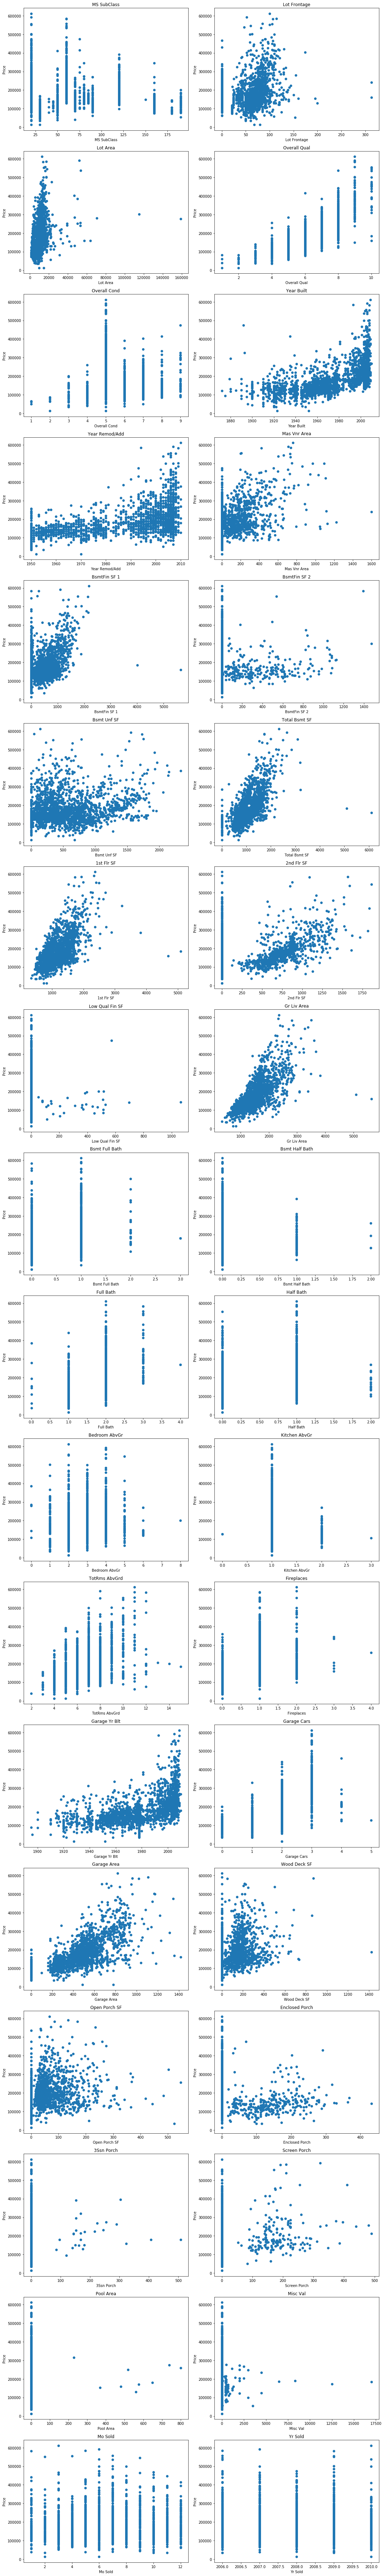

In [45]:
subplot_scatter(df[num_cols_no_ord],num_cols_no_ord,num_cols_no_ord)

In [46]:
#Create empty list to append outliers based on scatter plot
outlier_list = []
#index 2214 and 1839 lot area too big
df['Lot Frontage'].sort_values(ascending = False).head()

2214    313.0
1839    313.0
2754    200.0
1320    195.0
871     182.0
Name: Lot Frontage, dtype: float64

In [47]:
outlier_list.extend((2214,1839))

In [48]:
#index 214, 307, 1350 lot area too big
df['Lot Area'].sort_values(ascending = False).head()

214     215245
307     164660
1350    159000
1573    115149
2733     70761
Name: Lot Area, dtype: int64

In [49]:
outlier_list.extend((214,307,1350))

In [50]:
#index 2288 Mas Vnr Area too big
df['Mas Vnr Area'].sort_values(ascending = False).head()

2288    1600.0
116     1378.0
552     1290.0
260     1224.0
2764    1224.0
Name: Mas Vnr Area, dtype: float64

In [51]:
outlier_list.append(2288)

In [52]:
#index 1839,2764: BsmtFin SF 1, Total Bsmt SF and Gr Liv Area
df['BsmtFin SF 1'].sort_values(ascending = False).head()

1839    5644.0
2764    4010.0
164     2288.0
76      2260.0
104     2257.0
Name: BsmtFin SF 1, dtype: float64

In [53]:
outlier_list.extend((1839,2764))

In [54]:
#index 65 : BsmtFin SF 2 
df['BsmtFin SF 2'].sort_values(ascending = False).head()

65      1526.0
1649    1474.0
2571    1393.0
173     1164.0
1672    1127.0
Name: BsmtFin SF 2, dtype: float64

In [55]:
outlier_list.append(65)

In [56]:
#index 1707: For Low Qual Fin SF and Enclosed Porch
df['Low Qual Fin SF'].sort_values(ascending = False).head()

1707    1064
2118     697
1914     572
1199     528
1737     515
Name: Low Qual Fin SF, dtype: int64

In [57]:
outlier_list.append(1064)

In [58]:
#index 1845
df['Wood Deck SF'].sort_values(ascending = False).head()

1845    1424
2571     870
2450     857
919      736
2010     728
Name: Wood Deck SF, dtype: int64

In [59]:
outlier_list.append(1845)

In [60]:
#index 2764, 778, 1183
df['Misc Val'].sort_values(ascending = False).head(6)

2764    17000
778     15500
1183    12500
1644     8300
2104     6500
1259     4500
Name: Misc Val, dtype: int64

In [61]:
outlier_list.extend((2764,778,1183))

In [62]:
# List of outliers remove duplicates
outlier_list = list({id for id in outlier_list})

In [63]:
# Drop all outliers
df.drop(df.index[outlier_list],inplace = True)

In [64]:
# Split test and train set again after cleaning
test = df[df['SalePrice'].isnull()]
train = df[df['SalePrice'].notnull()]

In [65]:
train.to_csv('../datasets/train_cleaned.csv')
test.to_csv('../datasets/test_cleaned.csv')

In [ ]:
# Onto manipulation of features